# Modeling DepMap data

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product

In [2]:
gg.theme_set(gg.theme_minimal(base_family="Arial"))

In [3]:
RANDOM_SEED = 103

## Model 1. Single gene linear model with one covariate

Model the logFC of one gene in multiple cell lines using a single predictor: RNA expression.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta R \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta \sim \mathcal{N}(0, 1) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 20
- $\alpha$ = 0.5
- $\beta$ = -1
- $\sigma$ = 0.3

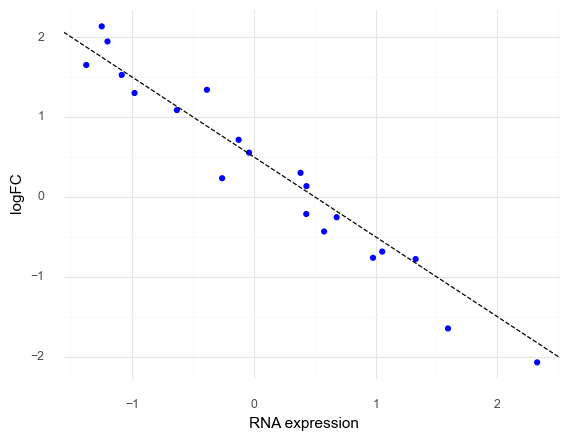

<ggplot: (8769487291493)>

In [4]:
N_CELL_LINES = 20
real_alpha = 0.5
real_beta = -1
real_sigma = 0.3

# Synthetic data
np.random.seed(RANDOM_SEED)
rna = np.random.randn(N_CELL_LINES)
logfc = real_alpha + real_beta * rna + np.random.normal(0, real_sigma, N_CELL_LINES)
data = pd.DataFrame({"rna": rna, "logfc": logfc})

(
    gg.ggplot(data, gg.aes("rna", "logfc"))
    + gg.geom_point(color="blue")
    + gg.geom_abline(slope=real_beta, intercept=real_alpha, linetype="--")
    + gg.labs(x="RNA expression", y="logFC")
)

In [5]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic("mu", alpha + beta * data.rna)

    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=data.logfc)

    model1_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model1_trace = pm.sample(1000)
    model1_post_check = pm.sample_posterior_predictive(
        model1_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:02<00:00, 797.61it/s]


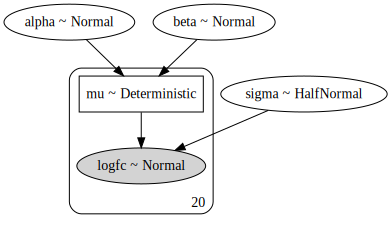

In [6]:
pm.model_to_graphviz(model1)

In [7]:
az_model1 = az.from_pymc3(
    model1_trace, posterior_predictive=model1_post_check, prior=model1_prior_check
)

In [8]:
var_names = ["alpha", "beta", "sigma"]
az.summary(az_model1, var_names=var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.439,0.067,0.304,0.552,0.002,0.001,1935.0,1923.0,1937.0,1369.0,1.0
beta,-1.105,0.062,-1.213,-0.980,0.001,0.001,1760.0,1760.0,1762.0,1376.0,1.0
sigma,0.277,0.052,0.190,0.376,0.001,0.001,1774.0,1709.0,1837.0,1317.0,1.0


/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

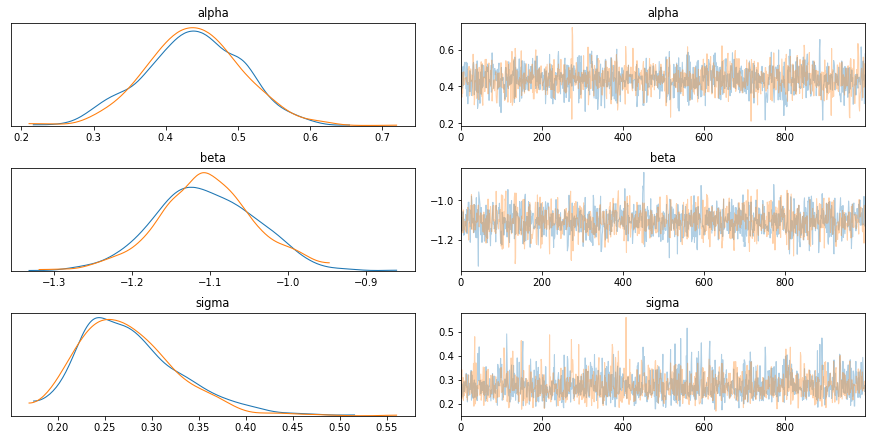

In [9]:
az.plot_trace(az_model1, var_names=var_names)
plt.show()

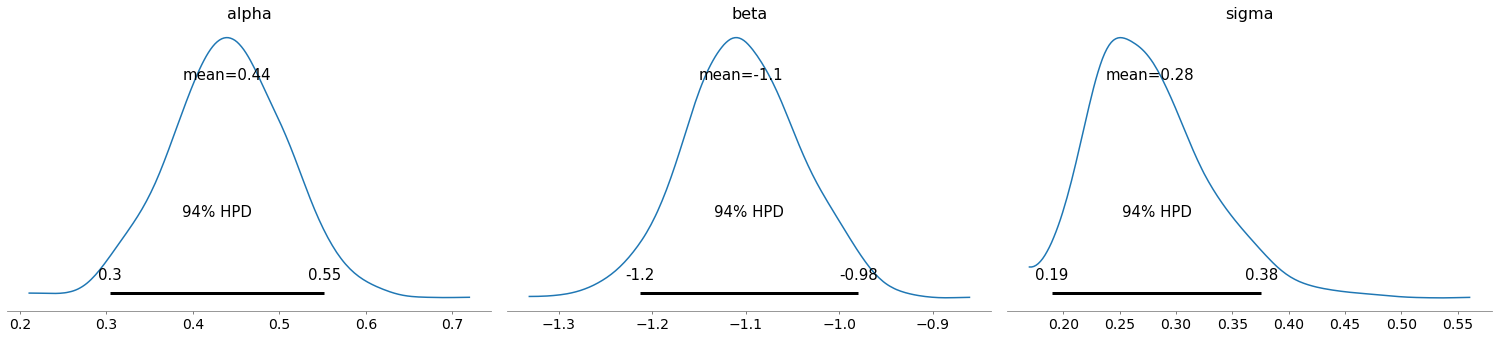

In [10]:
az.plot_posterior(az_model1, var_names=var_names)
plt.show()

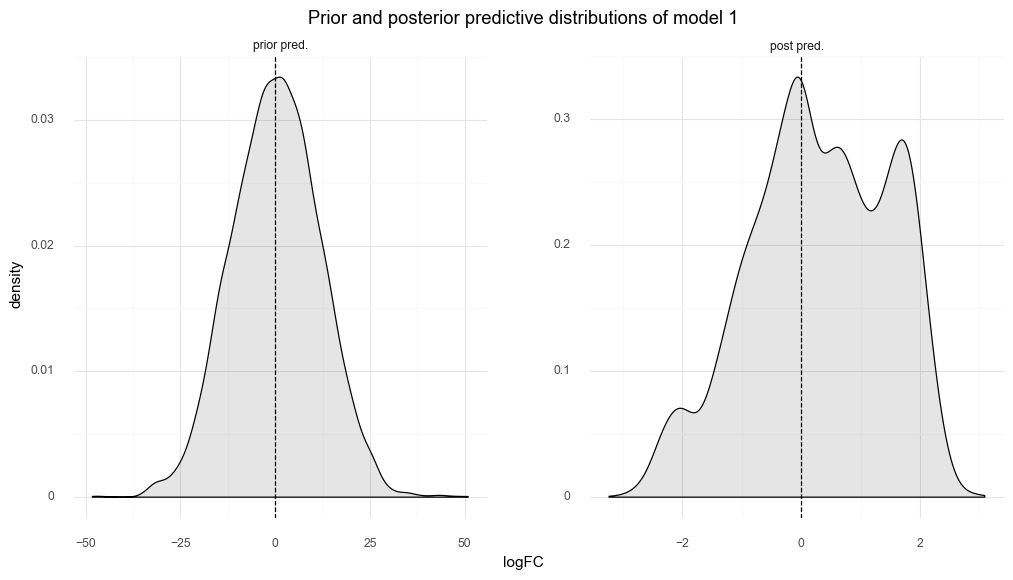

<ggplot: (8769490396641)>

In [11]:
prior_pred = (
    az_model1.prior_predictive.to_dataframe()
    .sample(frac=0.5)
    .assign(pred="prior pred.")
)
post_pred = (
    az_model1.posterior_predictive.to_dataframe()
    .sample(frac=0.2)
    .assign(pred="post pred.")
)
model1_preds = pd.concat([prior_pred, post_pred])
model1_preds["pred"] = pd.Categorical(
    model1_preds.pred, categories=["prior pred.", "post pred."]
)
(
    gg.ggplot(model1_preds, gg.aes("logfc"))
    + gg.facet_wrap("pred", nrow=1, scales="free")
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.scale_y_continuous(limits=(0, np.nan))
    + gg.labs(
        x="logFC",
        y="density",
        title="Prior and posterior predictive distributions of model 1",
    )
    + gg.theme(figure_size=[12, 6], subplots_adjust={"wspace": 0.25})
)

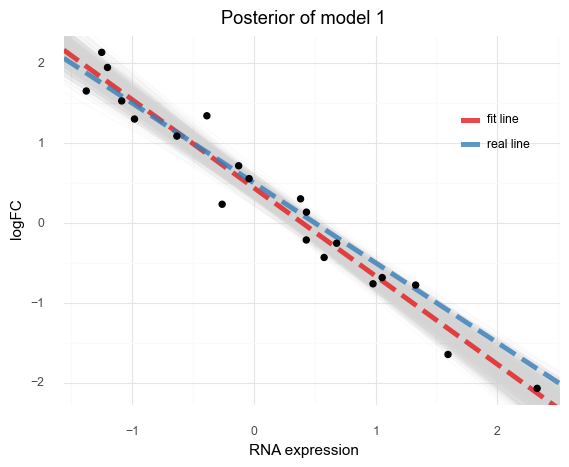

<ggplot: (8769489452853)>

In [12]:
post = az_model1.posterior.to_dataframe()

post_summary = pd.DataFrame(
    {
        "name": ["real line", "fit line"],
        "slope": [real_beta, post.mean()["beta"]],
        "intercept": [real_alpha, post.mean()["alpha"]],
    }
)

(
    gg.ggplot(post.sample(frac=0.1))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha"), alpha=0.1, color="lightgrey"
    )
    + gg.geom_abline(
        gg.aes(slope="slope", intercept="intercept", color="name"),
        data=post_summary,
        size=2,
        alpha=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(x="rna", y="logfc"), data=data, color="black", size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.8, 0.7))
    + gg.labs(x="RNA expression", y="logFC", title="Posterior of model 1", color="")
)

---

## Model 2. Multiple genes hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu_g = \alpha_g + \beta_g R \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 10) \qquad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 10) \qquad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 30
- number of genes: 5
- $\mu_\alpha$ = -1, $\sigma_\alpha$ = 1
- $\mu_\beta$ = -1, $\sigma_\beta$ = 2
- $\sigma$ = 0.3

In [13]:
np.random.seed(RANDOM_SEED)

num_cell_lines = 30
num_genes = 5

real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.5

real_alpha = np.random.normal(loc=real_mu_alpha, scale=real_sigma_alpha, size=num_genes)
real_beta = np.random.normal(loc=real_mu_beta, scale=real_sigma_beta, size=num_genes)

genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
rna = np.random.randn(num_genes, num_cell_lines)

logfc = (
    real_alpha
    + real_beta * rna.T
    + np.random.normal(loc=0, scale=real_sigma, size=(rna.T.shape))
)
logfc = logfc.T

In [14]:
rna_flat = rna.flatten()
logfc_flat = logfc.flatten()
gene_idx = np.repeat(range(num_genes), num_cell_lines)

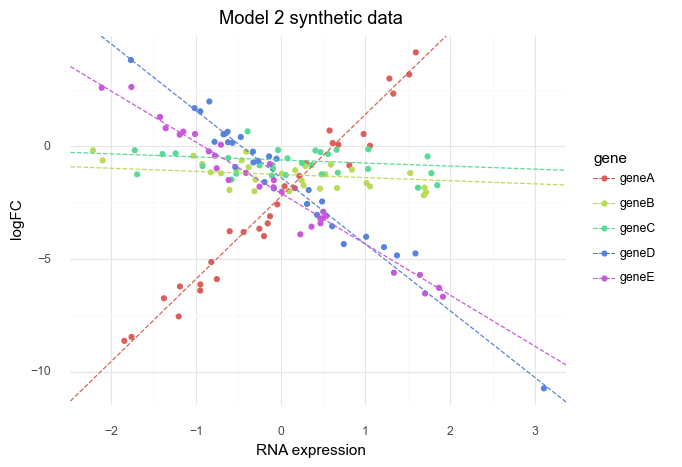

<ggplot: (8769326550461)>

In [15]:
tidy_data = pd.DataFrame(
    {"gene": [genes[i] for i in gene_idx], "rna": rna_flat, "logfc": logfc_flat}
)

tidy_real_data = pd.DataFrame({"alpha": real_alpha, "beta": real_beta, "gene": genes})


(
    gg.ggplot(tidy_data)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

In [16]:
with pm.Model() as model2:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 5)
    mu_beta = pm.Normal("mu_beta", 0, 2)
    sigma_beta = pm.HalfNormal("sigma_beta", 2)

    # Priors
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha, shape=num_genes)
    beta = pm.Normal("beta", mu_beta, sigma_beta, shape=num_genes)
    mu = pm.Deterministic("mu", alpha[gene_idx] + beta[gene_idx] * rna_flat)
    sigma = pm.HalfNormal("sigma", 5)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=logfc_flat)

    # Sampling
    model2_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model2_trace = pm.sample(2000, tune=2000)
    model2_post_check = pm.sample_posterior_predictive(
        model2_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains, 2 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 912.35draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 4000/4000 [00:04<00:00, 921.91it/s]


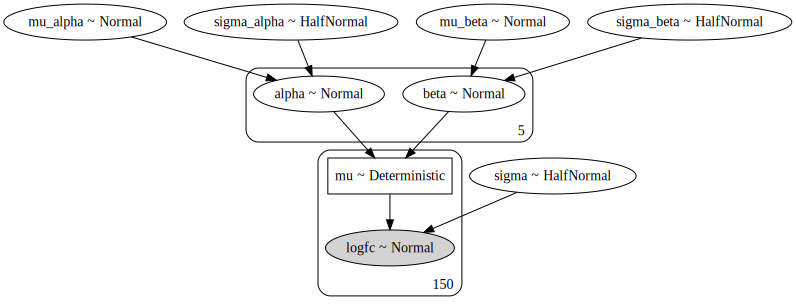

In [17]:
pm.model_to_graphviz(model2)

In [18]:
az_model2 = az.from_pymc3(
    trace=model2_trace, prior=model2_prior_check, posterior_predictive=model2_post_check
)
az.summary(az_model2, var_names=["alpha", "beta", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.414,0.097,-2.592,-2.228,0.001,0.001,7751.0,7751.0,7715.0,3293.0,1.0
alpha[1],-1.271,0.097,-1.446,-1.082,0.001,0.001,8893.0,8875.0,9014.0,2617.0,1.0
alpha[2],-0.764,0.099,-0.939,-0.568,0.001,0.001,9058.0,8647.0,9087.0,2851.0,1.0
alpha[3],-1.377,0.099,-1.563,-1.191,0.001,0.001,8102.0,8096.0,8119.0,3169.0,1.0
alpha[4],-2.149,0.103,-2.345,-1.960,0.001,0.001,7082.0,7049.0,7077.0,2720.0,1.0
beta[0],3.587,0.107,3.390,3.787,0.001,0.001,8371.0,8331.0,8413.0,2970.0,1.0
beta[1],-0.355,0.101,-0.536,-0.157,0.001,0.001,7656.0,6965.0,7639.0,2580.0,1.0
beta[2],-0.145,0.103,-0.336,0.051,0.001,0.001,8554.0,4536.0,8541.0,3048.0,1.0
beta[3],-2.839,0.102,-3.020,-2.643,0.001,0.001,6684.0,6622.0,6688.0,2715.0,1.0
beta[4],-2.359,0.094,-2.536,-2.183,0.001,0.001,7047.0,6979.0,6996.0,2634.0,1.0


In [19]:
# Real values
pd.DataFrame({"real alpha": real_alpha, "real beta": real_beta})

,real alpha,real beta
0,-2.249278,3.654438
1,-1.260331,-0.138414
2,-0.616207,-0.135368
3,-1.385461,-2.960023
4,-2.085137,-2.263930


/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

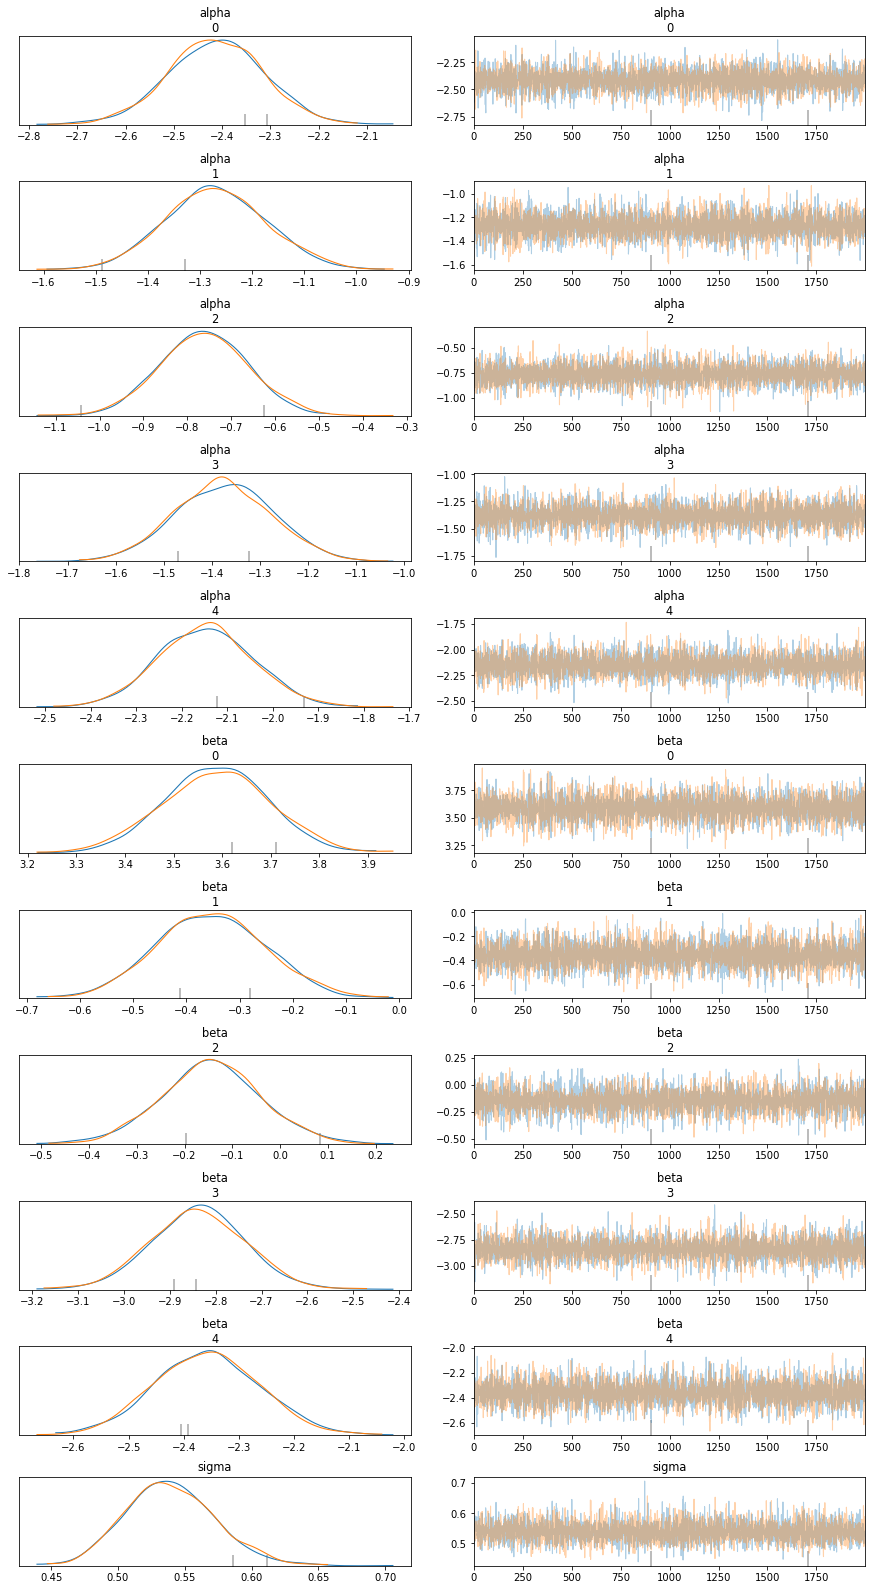

In [20]:
az.plot_trace(az_model2, var_names=var_names)
plt.show()

array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

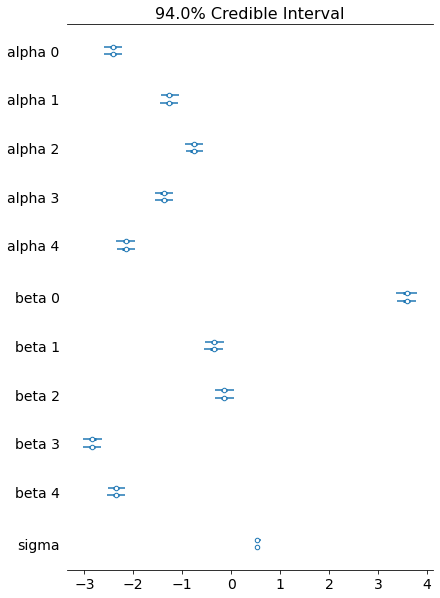

In [21]:
az.plot_forest(az_model2, var_names=var_names)

In [22]:
post = (
    az_model2.posterior.to_dataframe()
    .query("alpha_dim_0 == beta_dim_0")
    .reset_index()
    .groupby(["alpha_dim_0", "beta_dim_0"])
    .apply(lambda x: x.sample(frac=0.1))
    .reset_index(drop=True)
)

In [23]:
post.head()

,alpha_dim_0,beta_dim_0,chain,draw,mu_dim_0,mu_alpha,mu_beta,alpha,beta,sigma_alpha,sigma_beta,mu,sigma
0,0,0,1,1297,58,-2.005934,0.896238,-2.533306,3.537462,1.057965,2.704487,-1.491174,0.513907
1,0,0,0,1427,105,-1.612549,1.361572,-2.416255,3.616562,0.481319,2.038553,-1.192133,0.546126
2,0,0,0,1811,43,-1.090456,-0.989185,-2.351589,3.509903,0.789774,1.742488,-0.946303,0.543524
3,0,0,1,22,50,-1.913872,-0.134479,-2.430872,3.541012,0.541700,2.727996,-1.483219,0.489283
4,0,0,0,1620,46,-0.050011,-1.155751,-2.401856,3.715742,2.398424,3.717638,-1.243279,0.527196


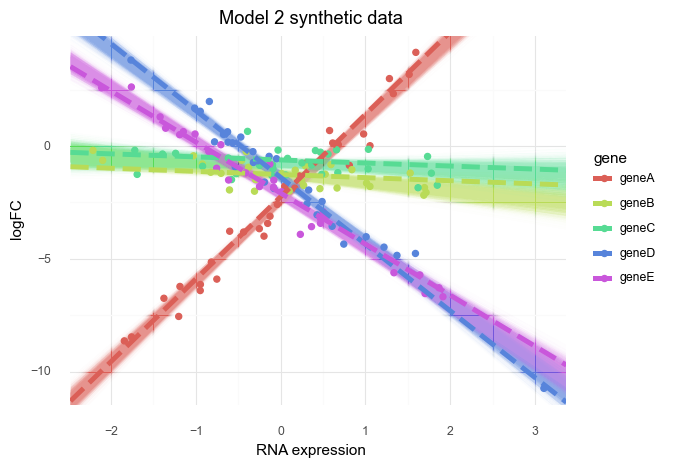

<ggplot: (8769325807021)>

In [24]:
post["gene"] = [genes[i] for i in post.alpha_dim_0]

(
    gg.ggplot(post)
    + gg.geom_abline(gg.aes(slope="beta", intercept="alpha", color="gene"), alpha=0.01)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"), data=tidy_data, size=2)
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
        size=2,
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

---

## Model 3. Multiple logFC readings per gene per cell line and only one RNA expression reading

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
There are multiple logFC readings per gene per cell line, but only one RNA expression reading.
(For now) there is only one varying effect for gene.

$
logFC_g \sim \mathcal{N}(\mu_g, \sigma) \\
\quad \mu_g = \alpha_g \\
\qquad \alpha_g \sim \mathcal{N}(\mu_{\alpha_g}, \sigma_{\alpha_g}) \\
\qquad \quad \mu_{\alpha_g} = \gamma_g + \delta_g R \\
\qquad \qquad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \qquad \quad \mu_\gamma \sim \mathcal{N}(0,5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \qquad \delta_g \sim \mathcal{N}(\mu_\delta, \sigma_\delta) \\
\qquad \qquad \quad \mu_\delta \sim \mathcal{N}(0,5) \quad \sigma_\delta \sim \text{Exp}(1) \\
\qquad \quad \sigma_{\alpha_g} \sim \text{Exp}(\sigma_g) \\
\qquad \qquad \sigma_g \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$

Simulated real values:

- number of cell lines: 30
- number of logFC data points per gene per cell line: 3
- number of genes: 5
- $\mu_\gamma = -1$
- $\sigma_\gamma = 0.4$
- $\mu_\delta = 0$
- $\sigma_\delta = 1$
- $\sigma_g = 0.4$
- $\sigma = 0.3$

In [25]:
np.random.seed(RANDOM_SEED)

# Synthetic data parmeters
num_cell_lines = 20
num_logfc_datum = 3
num_genes = 5

# Real hyper-parameter values
real_mu_gamma = -1
real_sigma_gamma = 0.4
real_mu_delta = 0
real_sigma_delta = 1
real_sigma_g = 0.4
real_sigma = 0.3


genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
gene_idx = list(range(num_genes))

cell_lines = ["cell" + a for a in string.ascii_uppercase[:num_cell_lines]]
cell_line_idx = list(range(num_cell_lines))

# RNA expression data (scaled within each gene)
rna = np.random.normal(loc=0, scale=1, size=(num_genes, num_cell_lines))
rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])
rna_data["rna"] = rna.flatten()

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])


real_gamma_g = np.random.normal(real_mu_gamma, real_sigma_gamma, (num_genes, 1))
real_delta_g = np.random.normal(real_mu_delta, real_sigma_delta, (num_genes, 1))
real_mu_alpha = (real_gamma_g + rna * real_delta_g).mean(axis=1)
real_sigma_alpha = np.random.exponential(real_sigma_g, num_genes)

real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha)
real_mu_g = real_alpha_g

ko_idx = list(range(num_logfc_datum))
logfc_data = pd.DataFrame(
    list(product(ko_idx, genes, cell_lines)), columns=["ko_idx", "gene", "cell_line"]
)

for c in ["gene", "cell_line"]:
    logfc_data[c] = pd.Categorical(logfc_data[c])


logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    g = logfc_data["gene"].cat.codes[i]
    logfc_data.loc[i, "logfc"] = np.random.normal(real_mu_g[g], real_sigma)

logfc_data

,ko_idx,gene,cell_line,logfc
0,0,geneA,cellA,-1.475160
1,0,geneA,cellB,-1.574389
2,0,geneA,cellC,-1.413401
3,0,geneA,cellD,-1.057404
4,0,geneA,cellE,-1.570743
...,...,...,...,...
295,2,geneE,cellP,0.758133
296,2,geneE,cellQ,0.352038
297,2,geneE,cellR,0.583303
298,2,geneE,cellS,0.818320


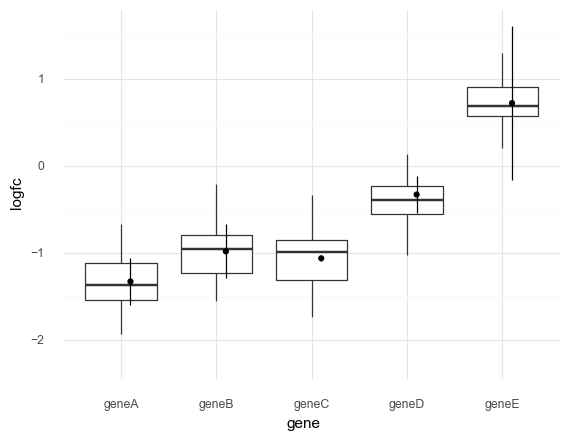

<ggplot: (8769488932725)>

In [26]:
known_logfc_values_df = pd.DataFrame(
    {"gene": genes, "logfc": real_alpha_g, "sd": real_sigma_alpha}
)
known_logfc_values_df["lower_err"] = (
    known_logfc_values_df["logfc"] - known_logfc_values_df["sd"]
)
known_logfc_values_df["upper_err"] = (
    known_logfc_values_df["logfc"] + known_logfc_values_df["sd"]
)

pos = gg.position_nudge(x=0.1)

(
    gg.ggplot(logfc_data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_linerange(
        gg.aes(ymin="lower_err", ymax="upper_err"),
        data=known_logfc_values_df,
        position=pos,
    )
    + gg.geom_point(data=known_logfc_values_df, position=pos)
)

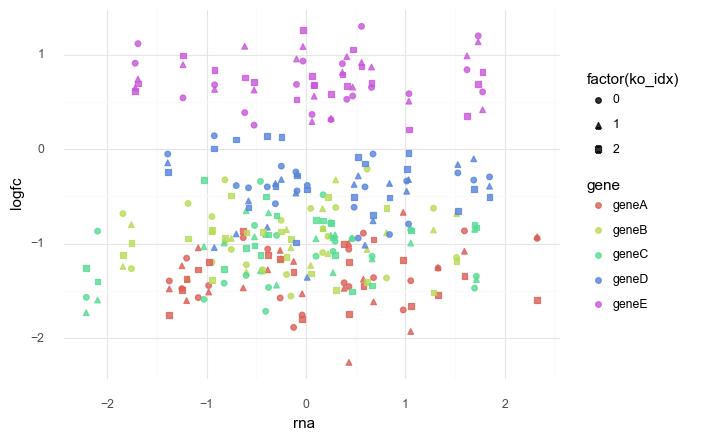

<ggplot: (8769488872769)>

In [27]:
merged_data = pd.merge(logfc_data, rna_data, how="inner", on=["gene", "cell_line"])

(
    gg.ggplot(merged_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(gg.aes(shape="factor(ko_idx)"), alpha=0.8, size=1.8)
)

**Conclusion**  
This was an incorrect understanding of how to use a predictor variable in a higher level of the model.
Though it is not the right model the purposes of this project, I'll leave it here as an example.

---

## Model 4. Multiple genes and multiple cell lines hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes and cell lines.
Also, to better mimic real data, I have added in the fact that there are multiple measures of logFC for each gene, but only one measure for RNA expression.

$
logFC_{g,c} \sim Normal(\mu_{g,c}, \sigma) \\
\quad \mu_g = \alpha_g + \gamma_c + \beta_g R \\
\qquad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \quad \mu_\alpha \sim \mathcal{N}(0, 5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\qquad \gamma_c \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \quad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \quad \mu_\beta \sim \mathcal{N}(0, 2) \quad \sigma_\beta \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$


Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: 3
- $\mu_\alpha = -1$, $\sigma_\alpha = 1$
- $\mu_\gamma = 0$, $\sigma_\gamma = 3$
- $\mu_\beta = -1$, $\sigma_\beta = 2$
- $\sigma = 0.3$

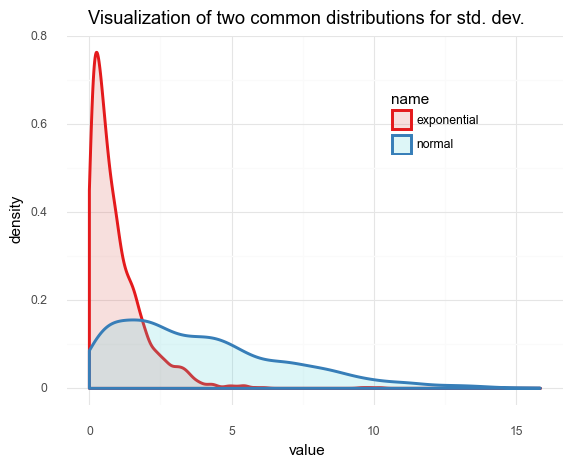

<ggplot: (8769488847345)>

In [28]:
N = 2000
np.random.seed(0)
sigma_dists = pd.DataFrame(
    {
        "name": np.repeat(["normal", "exponential"], N),
        "value": np.concatenate(
            [np.abs(np.random.normal(0, 5, N)), np.random.exponential(1, N)]
        ).flatten(),
    }
)

(
    gg.ggplot(sigma_dists, gg.aes("value"))
    + gg.geom_density(gg.aes(color="name", fill="name"), alpha=0.2, size=1.2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.7, 0.7))
    + gg.labs(title="Visualization of two common distributions for std. dev.")
)

In [34]:
np.random.seed(RANDOM_SEED)

# Real data parameters.
num_genes = 5
num_cell_lines = 20
num_logfc_datum = 3

# Real model values.
real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_gamma, real_sigma_gamma = 0, 3
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.3

# Sample from real distributions for the rest of the model parameters.
real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha, num_genes)
real_gamma_c = np.random.normal(real_mu_gamma, real_sigma_gamma, num_cell_lines)
real_beta_g = np.random.normal(real_mu_beta, real_sigma_beta, num_genes)

rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])

# RNA data (scaled by gene).
rna_data["rna"] = np.random.normal(0, 1, len(rna_data))

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])

logfc_data = []
for i in range(num_logfc_datum):
    x = rna_data.copy()
    x["sgrna_idx"] = i
    logfc_data.append(x)

logfc_data = pd.concat(logfc_data).reset_index(drop=True)

logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    gene_i = logfc_data["gene"].cat.codes[i]
    cell_line_i = logfc_data["cell_line"].cat.codes[i]
    mu = (
        real_alpha_g[gene_i]
        + real_gamma_c[cell_line_i]
        + real_beta_g[gene_i] * logfc_data.loc[i, "rna"]
    )
    logfc_data.loc[i, "logfc"] = np.random.normal(mu, real_sigma)

logfc_data

,gene,cell_line,rna,sgrna_idx,logfc
0,geneA,cellA,-1.187443,0,7.516370
1,geneA,cellB,0.299138,0,-1.184598
2,geneA,cellC,-0.947764,0,1.945419
3,geneA,cellD,-1.843382,0,-0.861100
4,geneA,cellE,0.810589,0,-6.491923
...,...,...,...,...,...
295,geneE,cellP,1.219362,2,0.194254
296,geneE,cellQ,-0.840481,2,-5.967522
297,geneE,cellR,0.607882,2,-0.719954
298,geneE,cellS,0.429605,2,1.885927


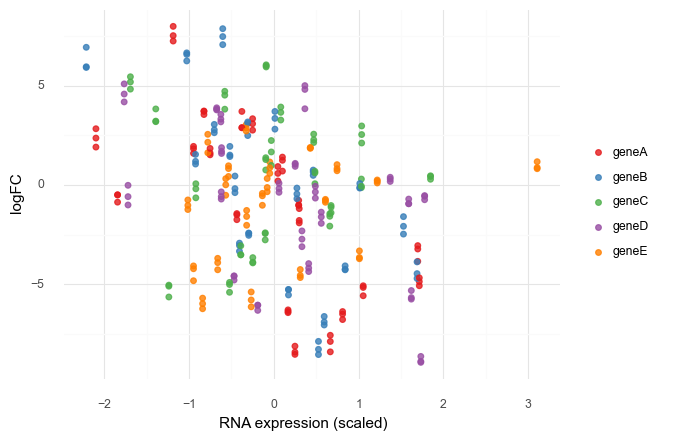

<ggplot: (8769312674937)>

In [35]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

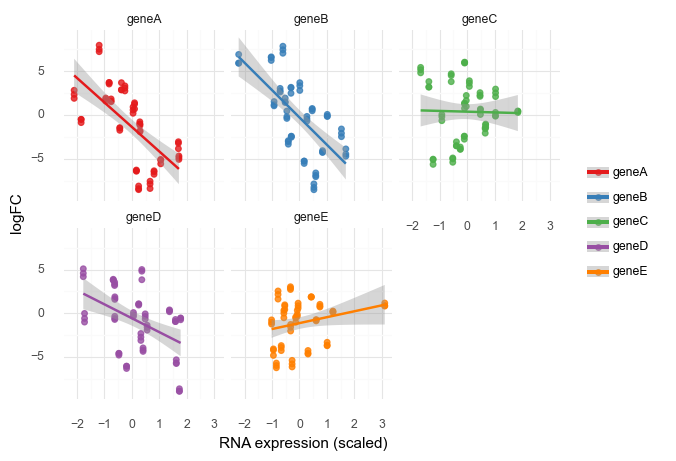

<ggplot: (8769312313805)>

In [36]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.facet_wrap("gene", nrow=2)
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.geom_smooth(method="lm")
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

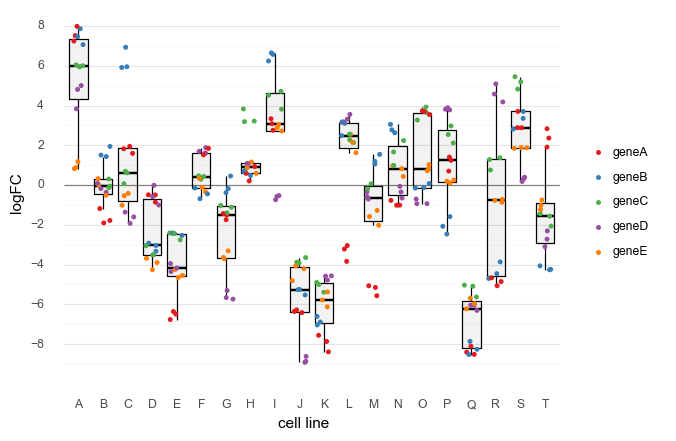

<ggplot: (8769327027405)>

In [37]:
(
    gg.ggplot(logfc_data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_boxplot(color="black", fill="black", alpha=0.05, outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.3, size=1)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.scale_y_continuous(breaks=range(-16, 16, 2))
    + gg.theme(panel_grid_major_x=gg.element_blank())
    + gg.labs(x="cell line", y="logFC", color="")
)

In [38]:
gene_idx = logfc_data["gene"].cat.codes.to_list()
cell_line_idx = logfc_data["cell_line"].cat.codes.to_list()

with pm.Model() as model4:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 2)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_gamma = pm.Normal("mu_gamma", 0, 2)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Priors
    alpha_g = pm.Normal("alpha_g", mu_alpha, sigma_alpha, shape=num_genes)
    gamma_c = pm.Normal("gamma_c", mu_gamma, sigma_gamma, shape=num_cell_lines)
    beta_g = pm.Normal("beta_g", mu_beta, sigma_beta, shape=num_genes)
    mu_gc = pm.Deterministic(
        "mu_gc",
        alpha_g[gene_idx] + gamma_c[cell_line_idx] + beta_g[gene_idx] * logfc_data.rna,
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu_gc, sigma=sigma, observed=logfc_data.logfc)

    # Sampling
    model4_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model4_trace = pm.sample(2000, tune=2000)
    model4_post_check = pm.sample_posterior_predictive(
        model4_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_g, gamma_c, alpha_g, sigma_beta, mu_beta, sigma_gamma, mu_gamma, sigma_alpha, mu_alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [02:35<00:00, 51.46draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 794.97it/s]


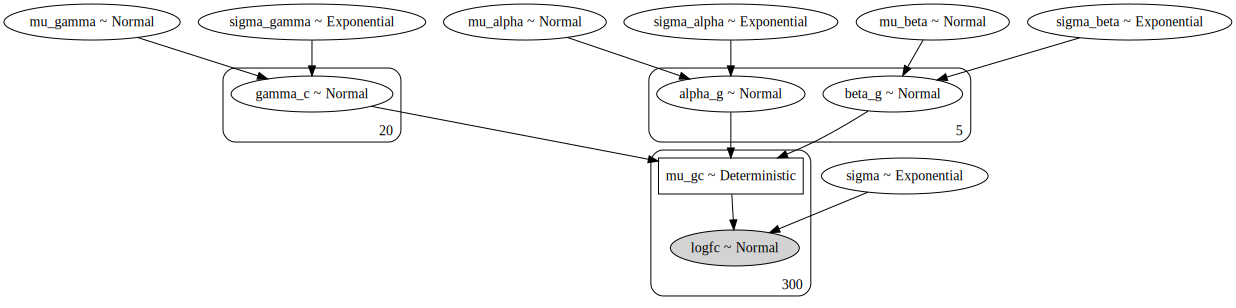

In [39]:
pm.model_to_graphviz(model4)

In [40]:
az_model4 = az.from_pymc3(
    trace=model4_trace, prior=model4_prior_check, posterior_predictive=model4_post_check
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

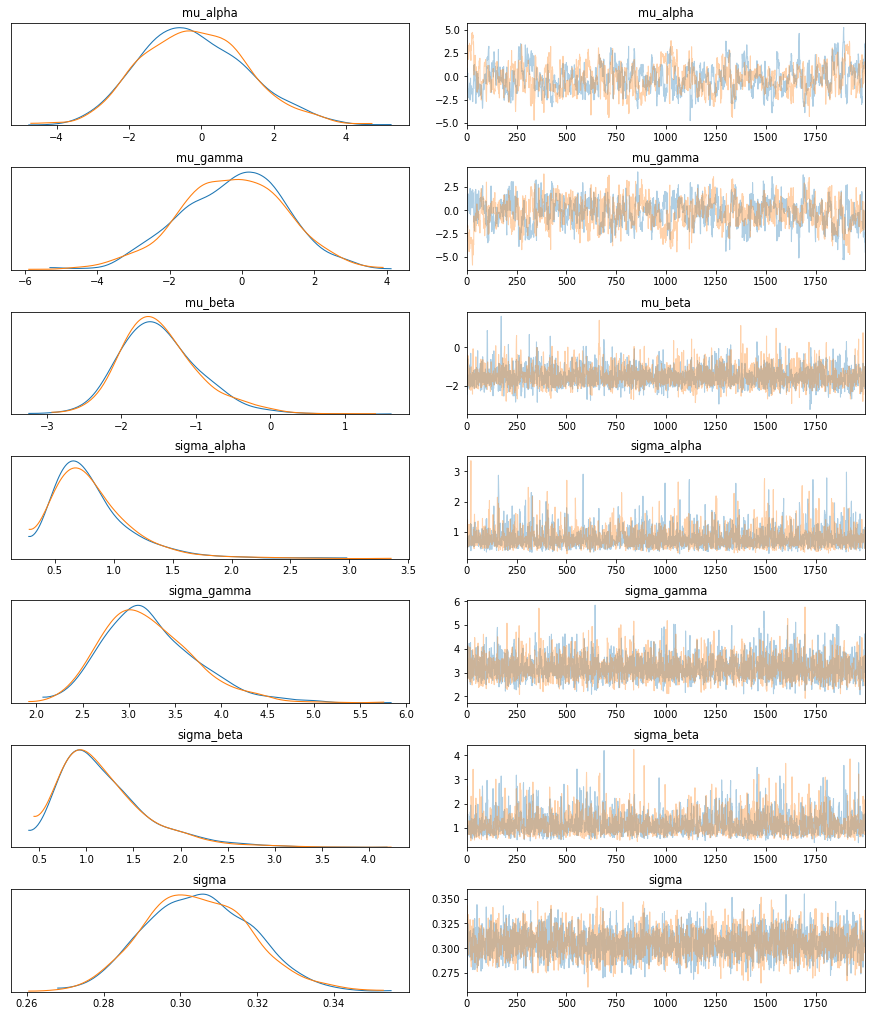

In [41]:
var_names1 = ["mu_" + a for a in ["alpha", "gamma", "beta"]]
var_names2 = ["sigma_" + a for a in ["alpha", "gamma", "beta"]]
az.plot_trace(az_model4, var_names=var_names1 + var_names2 + ["sigma"])
plt.show()

In [42]:
s = az.summary(az_model4, var_names=var_names1 + var_names2)
s["real_values"] = [
    real_mu_alpha,
    real_mu_gamma,
    real_mu_beta,
    real_sigma_alpha,
    real_sigma_gamma,
    real_sigma_beta,
]
s

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
mu_alpha,-0.215,1.455,-2.923,2.475,0.088,0.063,271.0,271.0,281.0,329.0,1.0,-1
mu_gamma,-0.284,1.441,-3.060,2.365,0.081,0.058,313.0,313.0,322.0,472.0,1.0,0
mu_beta,-1.483,0.534,-2.376,-0.407,0.011,0.008,2204.0,2204.0,2458.0,2038.0,1.0,-1
sigma_alpha,0.824,0.347,0.363,1.442,0.007,0.006,2194.0,1971.0,3154.0,2274.0,1.0,1
sigma_gamma,3.220,0.503,2.390,4.217,0.009,0.006,3434.0,3215.0,3750.0,2602.0,1.0,3
sigma_beta,1.191,0.478,0.506,2.064,0.010,0.007,2221.0,2095.0,2724.0,2324.0,1.0,2


In [43]:
az.summary(az_model4, var_names=["alpha_g"]).assign(real_values=real_alpha_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
alpha_g[0],-1.014,1.464,-3.873,1.610,0.091,0.065,257.0,257.0,269.0,308.0,1.0,-2.249278
alpha_g[1],0.047,1.465,-2.563,2.918,0.092,0.065,256.0,256.0,268.0,299.0,1.0,-1.260331
alpha_g[2],0.673,1.463,-1.971,3.484,0.091,0.070,257.0,221.0,268.0,295.0,1.0,-0.616207
alpha_g[3],-0.120,1.465,-2.835,2.653,0.092,0.065,256.0,256.0,268.0,293.0,1.0,-1.385461
alpha_g[4],-0.717,1.463,-3.455,2.014,0.091,0.065,257.0,257.0,269.0,295.0,1.0,-2.085137


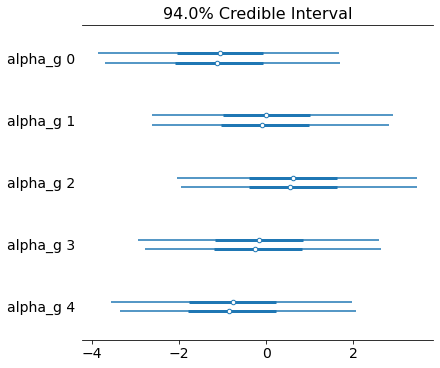

In [44]:
az.plot_forest(az_model4, var_names=["alpha_g"])
plt.show()

In [45]:
az.summary(az_model4, var_names=["beta_g"]).assign(real_values=real_beta_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
beta_g[0],-2.552,0.045,-2.633,-2.464,0.001,0.001,4058.0,4058.0,4060.0,2405.0,1.0,-2.634413
beta_g[1],-2.887,0.049,-2.980,-2.798,0.001,0.000,4987.0,4985.0,4991.0,2794.0,1.0,-2.892255
beta_g[2],-0.563,0.050,-0.664,-0.474,0.001,0.001,3627.0,3607.0,3662.0,2532.0,1.0,-0.558722
beta_g[3],-2.240,0.043,-2.324,-2.164,0.001,0.000,5926.0,5915.0,5923.0,2951.0,1.0,-2.201467
beta_g[4],-1.284,0.045,-1.365,-1.189,0.001,0.000,4700.0,4678.0,4698.0,2743.0,1.0,-1.305132


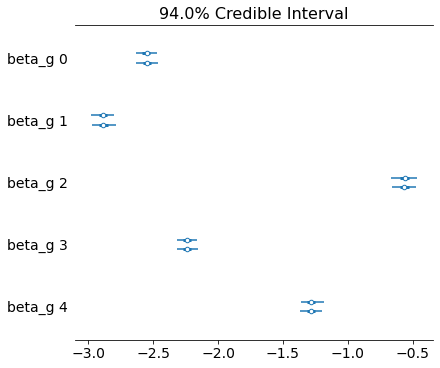

In [46]:
az.plot_forest(az_model4, var_names=["beta_g"])
plt.show()

In [47]:
az.summary(az_model4, var_names=["gamma_c"]).assign(real_values=real_gamma_c)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
gamma_c[0],5.528,1.464,2.643,8.114,0.091,0.065,257.0,257.0,268.0,288.0,1.0,6.981657
gamma_c[1],0.043,1.463,-2.768,2.700,0.091,0.065,257.0,257.0,269.0,298.0,1.0,1.292379
gamma_c[2],-0.023,1.468,-2.928,2.551,0.091,0.065,258.0,258.0,269.0,303.0,1.0,1.296947
gamma_c[3],-4.242,1.467,-7.167,-1.686,0.091,0.069,257.0,225.0,268.0,319.0,1.0,-2.940034
gamma_c[4],-3.311,1.463,-6.046,-0.629,0.091,0.070,257.0,219.0,268.0,295.0,1.0,-1.895896
gamma_c[5],0.572,1.467,-2.475,3.019,0.091,0.065,258.0,258.0,269.0,292.0,1.0,1.732326
gamma_c[6],-1.580,1.468,-4.443,1.038,0.092,0.072,256.0,209.0,267.0,307.0,1.0,-0.374273
gamma_c[7],1.762,1.466,-1.054,4.405,0.092,0.065,255.0,255.0,267.0,289.0,1.0,2.936844
gamma_c[8],3.383,1.466,0.610,6.067,0.092,0.065,256.0,256.0,268.0,301.0,1.0,4.784765
gamma_c[9],-4.818,1.466,-7.800,-2.308,0.091,0.069,259.0,230.0,271.0,303.0,1.0,-3.605834


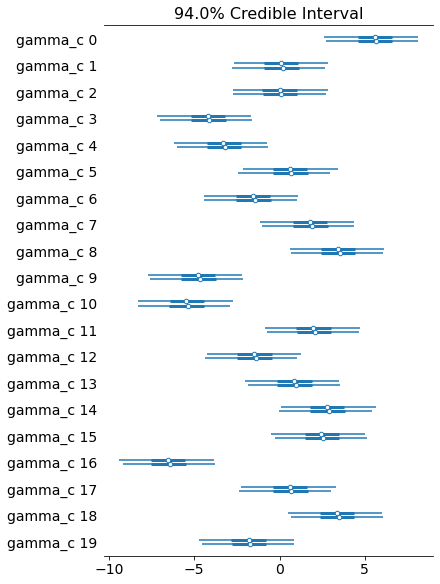

In [48]:
az.plot_forest(az_model4, var_names=["gamma_c"])
plt.show()

In [69]:
post_alpha_g = model4_trace.get_values(varname="alpha_g")
post_gamma_c = model4_trace.get_values(varname="gamma_c")
post_beta_g = model4_trace.get_values(varname="beta_g")
post_mu_gc = model4_trace.get_values(varname="mu_gc")

In [71]:
logfc_data.shape

(300, 5)

In [74]:
post_mu_gc.shape

(4000, 300)

In [88]:
post_mu_mean = post_mu_gc.mean(axis=0)
post_mu_hdi = np.array([az.hpd(x, credible_interval=0.89) for x in post_mu_gc.T])

logfc_post_df = logfc_data.copy()
logfc_post_df["post_logfc"] = post_mu_mean
logfc_post_df["hpi_lower"] = [x[0] for x in post_mu_hdi]
logfc_post_df["hpi_upper"] = [x[1] for x in post_mu_hdi]
logfc_post_df

,gene,cell_line,rna,sgrna_idx,logfc,post_logfc,hpi_lower,hpi_upper
0,geneA,cellA,-1.187443,0,7.516370,7.544614,7.390785,7.706855
1,geneA,cellB,0.299138,0,-1.184598,-1.734859,-1.879098,-1.604324
2,geneA,cellC,-0.947764,0,1.945419,1.381095,1.228576,1.537456
3,geneA,cellD,-1.843382,0,-0.861100,-0.552129,-0.737418,-0.380728
4,geneA,cellE,0.810589,0,-6.491923,-6.393723,-6.527592,-6.239647
...,...,...,...,...,...,...,...,...
295,geneE,cellP,1.219362,2,0.194254,0.127571,-0.022881,0.287405
296,geneE,cellQ,-0.840481,2,-5.967522,-6.196416,-6.337464,-6.040493
297,geneE,cellR,0.607882,2,-0.719954,-0.914405,-1.061922,-0.757333
298,geneE,cellS,0.429605,2,1.885927,2.057401,1.918837,2.200657


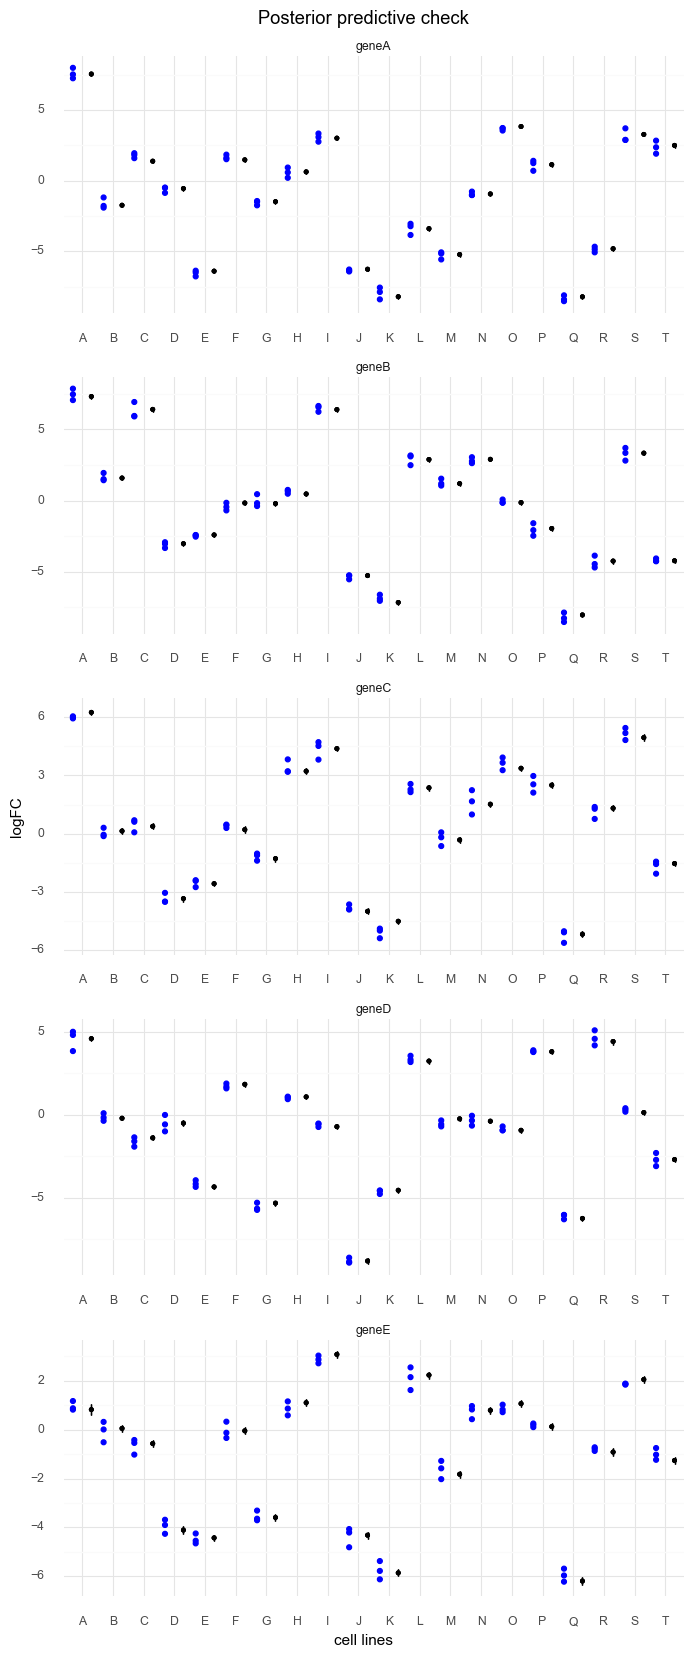

<ggplot: (8769329310481)>

In [98]:
(
    gg.ggplot(logfc_post_df, gg.aes(x="cell_line"))
    + gg.facet_wrap("gene", ncol=1, scales="free")
    + gg.geom_linerange(
        gg.aes(ymin="hpi_lower", ymax="hpi_upper"), position=gg.position_nudge(x=0.3)
    )
    + gg.geom_point(gg.aes(y="post_logfc"), position=gg.position_nudge(x=0.3), size=1)
    + gg.geom_point(gg.aes(y="logfc"), position=gg.position_nudge(x=-0.3), color="blue")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.theme(subplots_adjust={"hspace": 0.25, "wspace": 0.25}, figure_size=(8, 20))
    + gg.labs(x="cell lines", y="logFC", title="Posterior predictive check")
)

---

#### Notes

- Model where some cell lines tend to have higher RNA expression.